In [54]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from util import util
import os
import numpy as np
from tensorflow.keras import callbacks
import warnings
import pandas as pd
warnings.simplefilter("ignore")

# Load data
data_folder = os.path.join('..', 'data')
data = util.load_cmapss_data(data_folder)

# Focus on a subset of the data
data_by_src = util.split_by_field(data, field='src')
dt = data_by_src['train_FD004']

# Split training and test machines
trs_ratio = 0.25
tru_ratio = 0.5

np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep_s = int(trs_ratio * len(machines))
sep_u = int(tru_ratio * len(machines))
trsu_mcn = machines[:sep_s+sep_u]
ts_mcn = machines[sep_s+sep_u:]
trsu, ts = util.partition_by_machine(dt, trsu_mcn)

trs_mcn = trsu_mcn[:sep_s]
tru_mcn = trsu_mcn[sep_s:]
trs, tru_full = util.partition_by_machine(trsu, trs_mcn)

# Apply random censoring to the unsupervised data
tru = util.random_censoring(tru_full, rel_censoring_lb=0.5)

tr_mcn = np.hstack([trs_mcn, tru_mcn])
tr = pd.concat([trs, tru])

# Add time information
# Identify parameter and sensor columns
dt_in = list(data.columns[3:-1])

# Standardize parameters and sensors
trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields
ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = tr.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd

# Normalize RUL and time (cycle)
trmaxrul = tr['rul'].max()
ts_s['cycle'] = ts_s['cycle'] / trmaxrul
tr_s['cycle'] = tr_s['cycle'] / trmaxrul
ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul

# Add time (cycle) to the input columns
dt_in = dt_in + ['cycle']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Survival Analysis using Neural Models

## Open Issues with the Previous Approach

**Our probabilistic RUL model worked quite well**

...But it still has some weak spots

**What if we are not confident about using a Normal?**

* We could swap it for another distribution
* ...But it might not be easy to guess the correct choice

**What if the RUL depends strongly on what happens in the future?**

* Then, we would need a lot of runs to obtain a good marginalization
* ...And data availability is a critical issue in RUL estimation

**The last observation deserves further attention**

## Censoring

**In many domains, run-to-failure experiments are expensive to obtain**

...But _partial runs_ might abunant

* Broken industrial machines vs regularly maintained ones
* Deaths in organ transplant waiting lists vs alive patients

**The C-MAPSS dataset is very unrealistic from this point of view**

The simulator is good, but there are way too many experiments

* We can simulate limited availability of supervised data
* ...By randomly truncating a portion of the training set

**In survival analysis, the lack of key events is known as _censoring_**

In [55]:
print(f'In this notebook, censoring was applied to {100*tru_ratio/(trs_ratio+tru_ratio):.0f}% of the training experiments')

In this notebook, censoring was applied to 67% of the training experiments


## Censoring

**In our plots, censoring will cause irregularities in the sawtooth pattern**

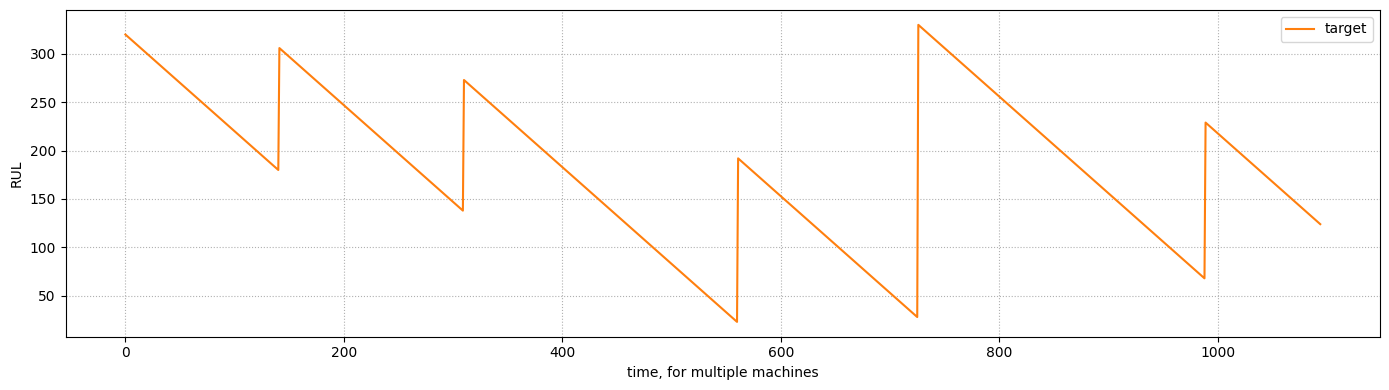

In [56]:
stop = 1095
util.plot_rul(target=tru['rul'][:stop], figsize=figsize, xlabel='time, for multiple machines', ylabel='RUL')

* We still can plot the RUL values, but only since we used _simulated_ censoring
* In a real use case, we would have _no RUL target for this data_

<div class=big>Can we still take advantage of this data? How?</div>

## Survival Function

**We could study the distribution of $T$ via its _survival function_**

The survival function of a variable $T$ is defined as:

$$
S(t) = P(T > t)
$$

I.e. it the probability that the entity "survives" at least until time $t$

* It is the complement of the cumulative probability function $F(t) = P(T \leq t)$

**We can account for conditioning factors**

...Which for the survival function only includes the _past_ behavior

$$
S(t, X_{\leq t}) = P(T > t \mid X_{\leq t})
$$

* This means _it cannot account for the future_
* ...But also that _it cannot overfit due to poor marginalization_

## ...And Hazard Function

**If we assume _discrete time_, then $S$ can be _factorized_**

$$
S(t, X_{\leq t}) = (1 - \lambda(t, X_{t})) (1 - \lambda(t-1, X_{t-1})) \ldots
$$

Where $\lambda$ is called _hazard function_

**The hazard function is _a conditional probability_**

...That of not surving one more step. Formally:

* $\lambda(t, X_{t})$ is the probability of _not surviving_  at time $t$
* ...Given that the entity _has survived_ until time $t-1$. I.e.:

$$
\lambda(t, X_{t}) = P(T > t \mid T > t-1, X_{t})
$$

As a side effect, $\lambda$ only depends on _one_ observation

## Our Plan

**We will attempt to _train an estimator $\hat{\lambda}_\theta(t, x_t)$_ for the hazard function**

* This requires _no assumption on the distribution_ (besides that of using $S$)
* It does _not risk_ overfitting due to _poor marginalization_
* And it makes sense even if we _do not observe a "death" event (censoring)_

As a side effect, we also _cannot account for future behavior_

**Additionally, $S$ and $\lambda$ have more limited uses**

We can still _define a threshold-based policy_, e.g. by checking whether:

$$
\hat{\lambda}_\theta(t, x_t) \geq \varepsilon
$$

...But we'll see that _making forecasts_ is not trivial and requires approximations

## Training a Hazard Estimator

**Before we get that, we need a way to train our $\hat{\lambda}_\theta$ estimator**

We can start by modeling the _probability of a survival event_

* Say the $k$-th experiment in our dataset ends at time $e_k$
* Then the corresponding probability according to our estimator is:

$$
\hat{\lambda}_\theta(e_k, x_{k,e_k}) \prod_{t = 1}^{e_k-1} (1 - \hat{\lambda}_\theta(t, x_{k,t}))
$$

Where $x_{k,t}$ is the available input data for experiment $k$ at time $t$

**This is the probability of:**

* Surviving all time steps from $1$ to $e_k-1$
* Not surviving at time $e_k$

## Training a Hazard Estimator

**We can now formulate a likelihood maximization problem**

Assuming we have $m$ experiments, we get:

$$
\mathop{\text{argmax}}_{\theta} \prod_{k=1}^{m} \hat{\lambda}_\theta(e_k, x_{k,e_k}) \prod_{t = 1}^{e_k-1} (1 - \hat{\lambda}_\theta(t, x_{k,t}))
$$


**Then, let's rewrite the formula:**

* Let $d_{kt} = 1$ iff $t = e_k$, i.e. if the experiment ends at time $k$
* ...And let $d_{kt} = 0$ otherwise. Then we can get:

$$
\mathop{\text{argmax}}_{\theta} \prod_{k=1}^{m} \prod_{t = 1}^{e_k} d_{k,t} \hat{\lambda}_\theta(t, x_{k,t}) + (1 - d_{k,t}) (1 - \hat{\lambda}_\theta(t, x_{k,t}))
$$

Now the two products can be freely swapped

## Training a Hazard Estimator

**Starting from:**

$$
\mathop{\text{argmax}}_{\theta} \prod_{k=1}^{m} \prod_{t = 1}^{e_k} d_{k,t} \hat{\lambda}_\theta(t, x_{k,t}) + (1 - d_{k,t}) (1 - \hat{\lambda}_\theta(t, x_{k,t}))
$$

We obtain an equivalent problem through a log transformation:

$$
\mathop{\text{argmax}_\theta} \sum_{k=1}^{m} \sum_{t = 1}^{e_k} \log \left( d_{k,t} \hat{\lambda}_\theta(t, x_{k,t}) + (1 - d_{k,t}) (1 - \hat{\lambda}_\theta(t, x_{k,t})) \right)
$$

Since either $d_{k,t} = 1$ or $d_{k,t} = 0$, we can also split the log argument:

$$
\mathop{\text{argmax}_\theta} \sum_{k=1}^{m} \sum_{t = 1}^{e_k} d_{k,t} \log \hat{\lambda}_\theta(t, x_{k,t}) + (1 - d_{k,t}) \log (1 - \hat{\lambda}_\theta(t, x_{k,t}))
$$

## Training a Hazard Estimator

**Finally, with a sign switch we get:**

$$
\mathop{\text{argmin}_\theta} - \sum_{k=1}^{m} \sum_{t = 1}^{e_k} d_{k,t} \log \hat{\lambda}_\theta(t, x_{k,t}) + (1 - d_{k,t}) \log (1 - \hat{\lambda}_\theta(t, x_{k,t}))
$$

> **Does this remind you of something?**

**This is a (binary) _crossentropy minimization_ problem!**

* $d_{k,t}$ has the same role as a class
* $\hat{\lambda}_\theta(t, x_{k,t})$ is the model output
* We have a sample for every experiment and time step (the double summation)





## Training a Hazard Estimator

**This means that our $\hat{\lambda}_\theta$ can be seen _as a classifier_**

* We just need to consider all samples in our dataset individually
* Then attach to them a class corresponding to $d_{kt}$
* ...And finally we can train a neural classifier as usual

The model output will be _an estimate of the hazard function_

**This is almost precisely _what we did in our classification approach_**

...But now we have _a much better interpretation_

* We know how to define the classes
* We better know how to interpret the output
* We know the semantic for a threshold-based policy
* We know that we can safely deal with censoring

## Classes and Models

**Let's start by defining the classes**

We check when the RUL is 0 (this the same as $t = e_k$)

In [57]:
tr_lbl = (tr['rul'] == 0)
ts_lbl = (ts['rul'] == 0)

Then we can build a (usual) classification model:

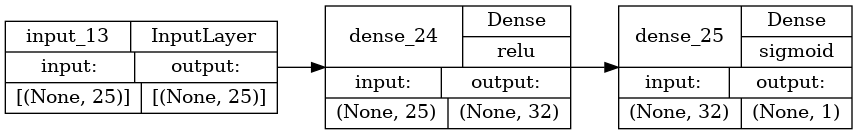

In [58]:
nnl = util.build_nn_model(input_shape=(len(dt_in), ), output_shape=1, hidden=[32], output_activation='sigmoid')
util.plot_nn_model(nnl)

## Effect on Censoring on the Distribution

**The new approach allows us to use censored data**

This is good, but it also has the effect of altering the distribution

* For end-to-failure experiments, are samples follow their natural distribution
* ...But censored data includes no end event, causing a skew

**We can try to account for that by using _sample weights_**

* Intuitively, if the censored data is equal to 100% of the sample with 0 label
* ...That will make the 0 label apparently twice as likely

Therefore, we can discount censored samples in the distribution:

In [59]:
n_zeros = (tr_lbl == False).sum()
class_weights = np.array([(n_zeros - len(tru)) / n_zeros, 1.])
sample_weight = np.choose(tr_lbl, class_weights)

## Training the Hazard Estimator

**Then we train the hazard estimator as any other classifier**

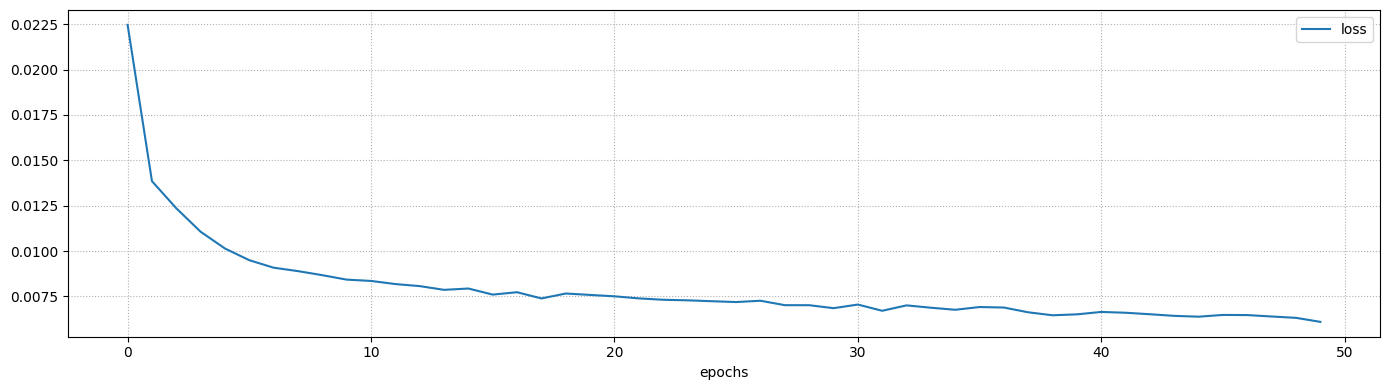

Final loss: 0.0061 (training)


In [60]:
nnl = util.build_nn_model(input_shape=(len(dt_in), ), output_shape=1, hidden=[32], output_activation='sigmoid')
history = util.train_nn_model(nnl, tr_s[dt_in], tr_lbl, loss='binary_crossentropy', epochs=50,
        verbose=0, patience=10, batch_size=32, validation_split=0.0, sample_weight=sample_weight)
util.plot_training_history(history, figsize=figsize)

## Inspecting Hazards

**We will start our evaluation by inspecting the hazard values**

First for (part of) the _training set_:

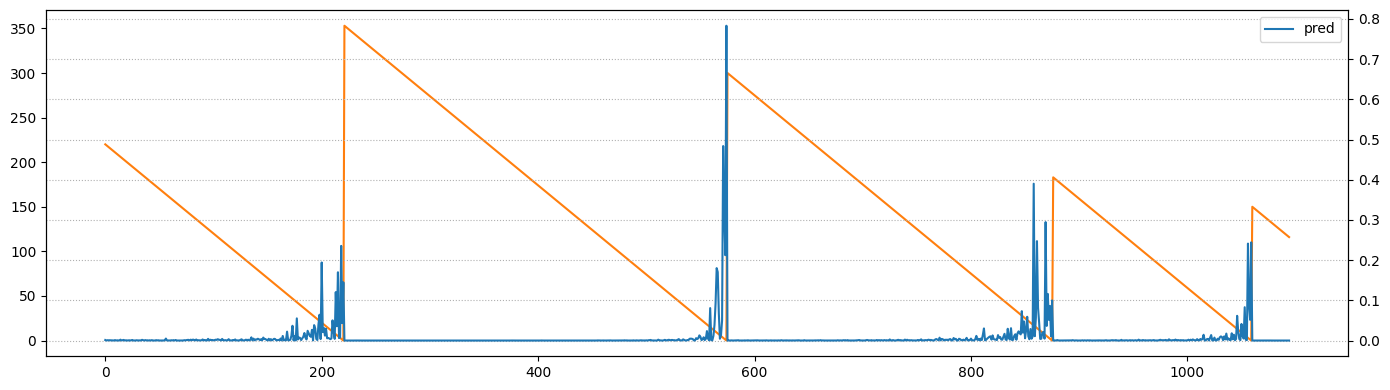

In [61]:
tr_pred = nnl.predict(tr_s[dt_in], verbose=0).ravel()
stop = 1095
util.plot_rul(pred=tr_pred[:stop], target=tr['rul'][:stop], same_scale=False, figsize=figsize)

## Inspecting Hazards

**We will start our evaluation by inspecting the hazard values**

...And here for (part of) the _test set_:

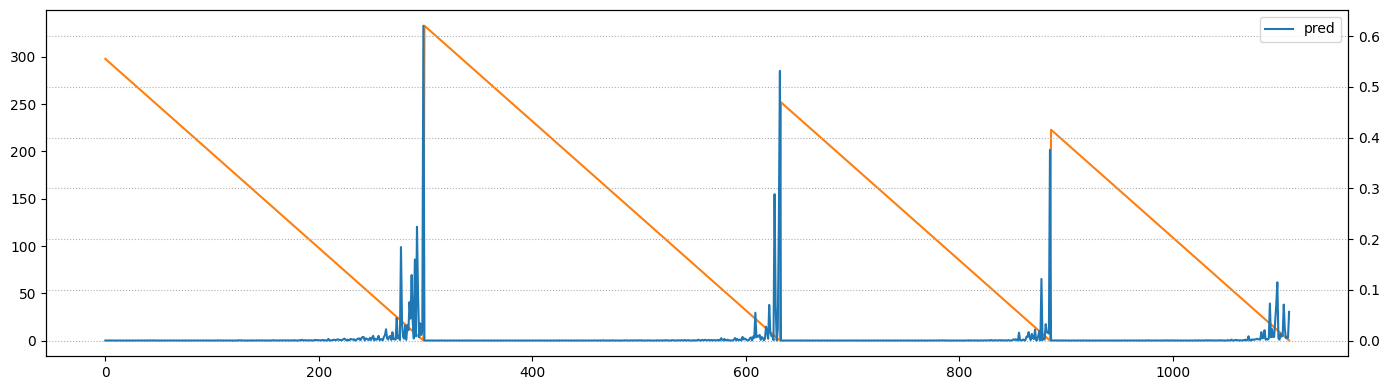

In [62]:
ts_pred = nnl.predict(ts_s[dt_in], verbose=0).ravel()
stop = 1110
util.plot_rul(pred=ts_pred[:stop], target=ts['rul'][:stop], same_scale=False, figsize=figsize)

## Hazard-based Policies

**We can define a policy based on the $\hat{\lambda}_\theta$ estimator as usual**

Namely, we trigger maintenance when:

$$
\hat{\lambda}_\theta(t, x_t) \geq \varepsilon
$$

The threshold can be defined again based on some cost metric

**Some comments**

* The old classifier-based approach still makes sense
* ...Though reasoning in terms of hazard function can be more versatile
* This approach can be combined with a sliding window input
* ...And smoothing might be be a good idea to avoid accidental triggering

## Using Hazards for Forecasting

**Additionally, we can use $\hat{\lambda}_\theta$ to perform forecasting**

In particular, we know the probability of surving _$n$ more_ steps is given by:

$$
\frac{S(t+n)}{S(t)} = \prod_{h=0}^{n} (1 - \lambda(t+h, X_{t+h}))
$$

...Which we can approximate (for a run $k$) as:

$$
\frac{S(t+n)}{S(t)} \simeq \prod_{h=0}^{n} (1 - \hat{\lambda}_\theta(t+h, x_{k,t+h}))
$$

* In theory, we can forecast survival probabilities arbitrarily far
* ...But in practice there is an issue

## Using Hazards for Forecasting

**The formula requires access to _future values_ of the $X_t$ variable**

$$
\frac{S(t+n)}{S(t)} \simeq \prod_{h=0}^{n} (1 - \hat{\lambda}_\theta(t+h, \color{red}{x_{k,t+h}}))
$$

* Unfortunately, we cannot access those in real life :-(
* We have two main options to deal with this

**First, can _ignore time-varying input_ in our estimator**

Formally, this is the same as marginalizing out all time-varying factors

* $\hat{\lambda}_\theta(t, x_t)$ becomes $\hat{\lambda}_\theta(t, x)$, for a fixed $x$
* $x$ represents some stable information, e.g. component type, genetics

In some cases, this is perfectly viable approach

## Using Hazards for Forecasting

**Second, we can attempt to _predict future $x_t$_ values**

This is viable as long as our predictions are good enough

* We can use a second ML estimator to predict $x_t$
* ...Or as a special case we can rely on the simple _persistence model_

**In practice, we just assume $x_t$ is stable for some time**

With this simple assumption, we get:

$$
\frac{S(t+n)}{S(t)} \simeq \prod_{h=0}^{n} (1 - \hat{\lambda}_\theta(t+h, x_{k,t}))
$$

* Unlike the original expression, this is easy to compute
* ...And it might be a reasonable approximation for shorter time horizons

## Approximate Future Hazard 

**Let's check this approximate future hazard for one of our test runs**

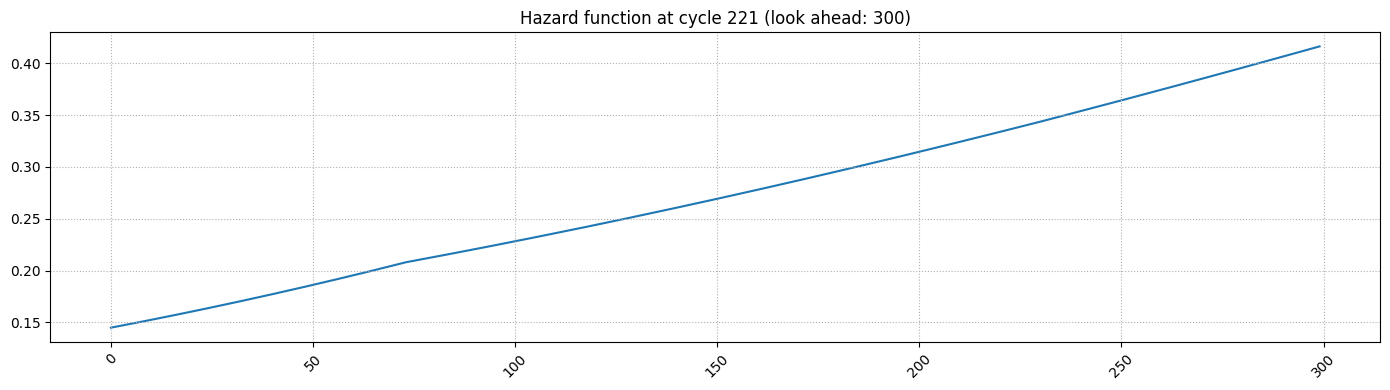

In [63]:
ref_sample = tr_s.iloc[220]
look_ahead = 300
hazard = util.predict_cf(nnl, ref_sample[dt_in], columns='cycle',
                         values=ref_sample['cycle'] + np.arange(look_ahead)/trmaxrul)
util.plot_series(hazard, figsize=figsize, title=f'Hazard function at cycle {ref_sample["cycle"]*trmaxrul:.0f} (look ahead: {look_ahead})')

* The model has learned that time has an effect on $\lambda$

## Approximate Conditional Survival

**We can then estimate the conditional survival probability**

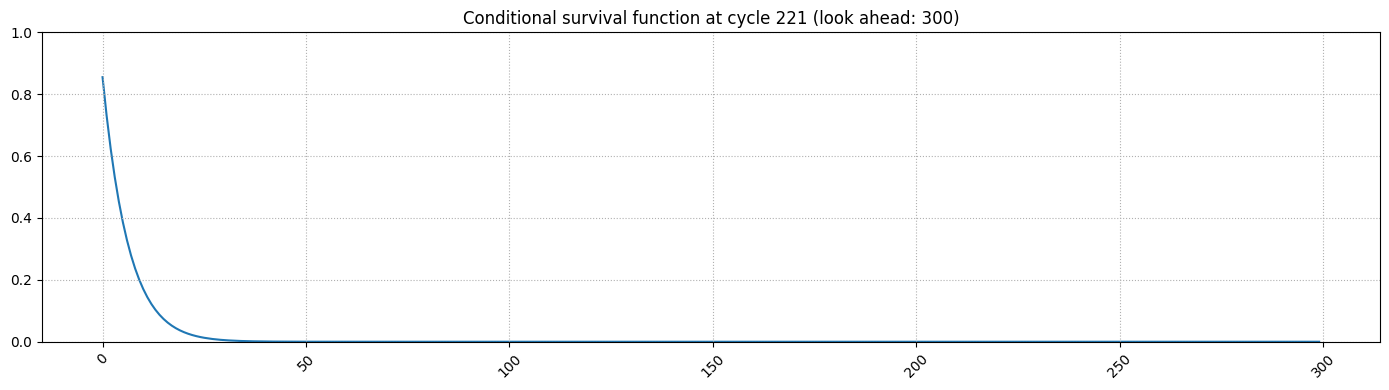

In [64]:
survival = pd.Series(data=np.cumprod(1-hazard))
util.plot_series(survival, figsize=figsize, ylim=(0,1),
                 title=f'Conditional survival function at cycle {ref_sample["cycle"]*trmaxrul:.0f} (look ahead: {look_ahead})')

The chance of being still running is smaller even in a few tens of steps

## Approximate Conditional Survival

**We can continuously compute $n$-step ahead conditional survival**

Here's an example for 30-steps ahead, on the first test set experiment

In [65]:
ref_run = ts_s[ts_s['machine'] == ts_s.iloc[0]['machine']]
look_up_window = np.arange(30)/trmaxrul
rolling_survival = util.rolling_survival_cmapss(hazard_model=nnl, data=ref_run[dt_in], look_up_window=look_up_window)
rolling_survival.columns = [f'S(t+{h})/S(t)' for h in range(30)]
rolling_survival.head()

,S(t+0)/S(t),S(t+1)/S(t),S(t+2)/S(t),S(t+3)/S(t),S(t+4)/S(t),S(t+5)/S(t),S(t+6)/S(t),S(t+7)/S(t),S(t+8)/S(t),S(t+9)/S(t),...,S(t+20)/S(t),S(t+21)/S(t),S(t+22)/S(t),S(t+23)/S(t),S(t+24)/S(t),S(t+25)/S(t),S(t+26)/S(t),S(t+27)/S(t),S(t+28)/S(t),S(t+29)/S(t)
321,0.999979,0.999958,0.999937,0.999916,0.999895,0.999874,0.999852,0.999831,0.999809,0.999787,...,0.999540,0.999517,0.999494,0.999470,0.999447,0.999423,0.999400,0.999376,0.999352,0.999328
322,0.999887,0.999774,0.999661,0.999547,0.999433,0.999318,0.999202,0.999086,0.998970,0.998853,...,0.997535,0.997412,0.997289,0.997165,0.997040,0.996915,0.996790,0.996664,0.996537,0.996410
323,0.999981,0.999963,0.999944,0.999925,0.999906,0.999886,0.999867,0.999848,0.999828,0.999809,...,0.999587,0.999566,0.999545,0.999524,0.999503,0.999482,0.999460,0.999439,0.999417,0.999395
324,0.999996,0.999992,0.999988,0.999984,0.999980,0.999976,0.999972,0.999968,0.999964,0.999960,...,0.999914,0.999910,0.999906,0.999901,0.999897,0.999893,0.999888,0.999884,0.999879,0.999875
325,0.999993,0.999987,0.999980,0.999973,0.999966,0.999960,0.999953,0.999946,0.999939,0.999932,...,0.999855,0.999848,0.999841,0.999834,0.999827,0.999820,0.999813,0.999806,0.999798,0.999791


* Each column contains the conditional survival $h$ steps away

## Approximate Conditional Survival

**Here's a plot over time (after some smoothing)**

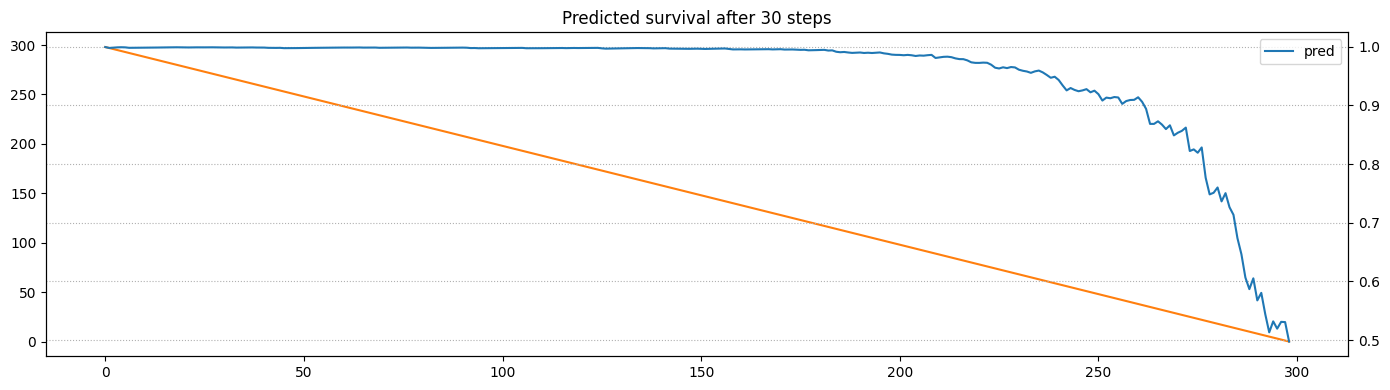

In [66]:
rolling_survival_last = rolling_survival[rolling_survival.columns[-1]].ewm(15).mean()
util.plot_rul(pred=rolling_survival_last[:stop], target=ref_run['rul']*trmaxrul, same_scale=False,
              figsize=figsize, title='Predicted survival after 30 steps')

* Remember that this is a stochastic phenomenon
* So, even an 80% chance is quite dangerous to take!

## In Hindsight...

**This whole lecture block was about _probabilistic models_**

* The techniques we covered are interesting per-se
* ...And way more useful in practice than you might think

...But what the core message I hope you glimpsed is another

> **Machine Learning models are _not inflexible_ tools**

* If you spot a limit, or a piece of information you can use
* ...And you know what you are doing

**Then you can _dramatically change_ their behavior!**